# Zero-Shot Learning (ZSL) Training and Prediction Results

In [2]:
from __future__ import print_function, division

import sys
import platform
import time
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

# this is necessary to use the common functions
# assumes directory structure was maintained
sys.path.insert(0, '../common/')
# from common.torch_utils import train_model,get_device
# from torch_utils import (train_model, 
#                          mnist_dataloader, 
#                          dataset_preview)
from torch_utils import *

# print some versions
print(f'Python Version:      {platform.python_version()}')
print(f'PyTorch Version:     {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')
print(f'CUDA Version:        {torch.version.cuda}')

# get device (defaults to GPU if available)
device = get_device()

Python Version:      3.7.8
PyTorch Version:     1.7.1+cu101
Torchvision Version: 0.8.2+cu101
CUDA Version:        10.1

***********************************
GPU Available:  True
Current Device: cuda:0 (Tesla V100-SXM2-16GB)
***********************************



## Data Preprocessing
We need to collect the MNIST data and create the dataloaders for PyTorch. To make a clean notebook, we have created a helper function to do most of the work (refer to `/src/common/torch_utils.py`). For training we will use a batch_size of 32 images, similar to the base model. To demonstrate the capabilities of ZSL on limited datasets, we must take a two step approach:
1. Training ZSL using the same baseline process (i.e., on the entire MNIST dataset)
2. Training ZSL using a small subset of the MNIST dataset (we will try a few sizes)

We can then we will have a matrix of comparisons:  

||||
|-|-|-|
||ZSL+|Baseline+|
|ZSL-|||
|Baseline-|||

Before we dive into the MNIST dataset, let's experiment using the data from [1].

$$
@inproceedings{li2019rethinking,
  title={Rethinking Zero-Shot Learning: A Conditional Visual Classification Perspective},
  author={Li, Kai and Min, Martin Renqiang and Fu, Yun},
  booktitle={Proceedings of the IEEE International Conference on Computer Vision},
  pages={3583--3592},
  year={2019}
}


In [2]:
# get the example data
zsl_data_dir = '../../data/zsl-example'
zsl_example_data = 'http://www.robots.ox.ac.uk/~lz/DEM_cvpr2017/data.zip'
if not os.path.isdir(zsl_data_dir):
    os.mkdir(zsl_data_dir)
# download data and clone project
# ! wget $zsl_example_data -P $zsl_data_dir 
# ! git clone https://github.com/kailigo/cvcZSL.git

zsl_data_zip = os.path.join(zsl_data_dir,os.path.basename(zsl_example_data))
if os.path.isfile(zsl_data_zip):
    import zipfile
    with zipfile.ZipFile(zsl_data_zip,"r") as zip_ref:
        zip_ref.extractall(zsl_data_dir)
    # cleanup, we don't need the zip now

    os.remove(zsl_data_zip)
    if not os.path.isfile(zsl_data_zip):
        print('Clean-up complete!')
else:
    print(f'Nothing to unzip, \'{zsl_data_zip}\' does not exist!')



tmp = os.path.splitext(os.path.basename(zsl_example_data))[0]
zsl_data_dir = os.path.join(zsl_data_dir,tmp)
if not os.path.isdir(zsl_data_dir):
    print('ERROR: ZSL example data dir does not exist, \'{zsl_data_dir}\'')

Nothing to unzip, '../../data/zsl-example/data.zip' does not exist!


In [4]:
AwA1_data = os.path.join(zsl_data_dir,'AwA1_data')
model_dir = 'models'
log_dir = 'logs'
if not os.path.isdir(model_dir): os.mkdir(model_dir)
if not os.path.isdir(log_dir): os.mkdir(log_dir)

# run the example training script
! python cvcZSL/train.py --dataset $AwA1_data --ways 16 --shots 4 --lr 1e-5 \
--opt_decay 1e-4 --step_size 500 --num_epochs 10 \
--log_file $log_dir/eps_lr5_opt4_ss500_w16_s4 \
--model_file $model_dir/lr5_opt4_ss500_w16_s4.pt

Namespace(dataset='../../data/zsl-example/data/AwA1_data', gamma=0.5, hidden_dim=1600, log_file='logs/eps_lr5_opt4_ss500_w16_s4', log_to_file=True, lr=1e-05, model_file='models/lr5_opt4_ss500_w16_s4.pt', nthreads=8, num_epochs=10, opt_decay=0.0001, shots=4, step_size=500, ways=16, weight_model='weightnet')
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
cvcZSL/train.py:84: UserWarning: This overload of baddbmm is deprecated:
	baddbmm(Number beta, Tensor input, Number alpha, Tensor batch1, Ten

In [13]:
print(AwA1_data)
! python cvcZSL/test.py --dataset $AwA1_data --model_file models/lr5_opt4_ss500_w16_s4.pt

../../data/zsl-example/data/AwA1_data
Namespace(dataset='../../data/zsl-example/data/AwA1_data', gamma=0.5, hidden_dim=1600, log_file='temp.log', log_to_file=True, lr=1e-05, model_file='models/lr5_opt4_ss500_w16_s4.pt', nthreads=8, num_epochs=1000, opt_decay=0.001, shots=4, step_size=200, ways=32, weight_model='weightnet')
Traceback (most recent call last):
  File "cvcZSL/test.py", line 160, in <module>
    model = torch.load(model_file_name)
  File "/opt/conda/lib/python3.7/site-packages/torch/serialization.py", line 581, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/opt/conda/lib/python3.7/site-packages/torch/serialization.py", line 230, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/opt/conda/lib/python3.7/site-packages/torch/serialization.py", line 211, in __init__
    super(_open_file, self).__init__(open(name, mode))
FileNotFoundError: [Errno 2] No such file or directory: '../../data/zsl-example/data/AwA1_data/models/lr5_opt4_ss500_w1

# Code Testing
## This is just to test the limited dataset creation
Let's now create a limited dataset for ZSL that we can use for training. Recall that for ZSL we are interested in splitting off a couple of classes. 

Data will be located in '../../data'
Dataset sizes: {'train': 6500, 'val': 1073, 'pred': 11}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


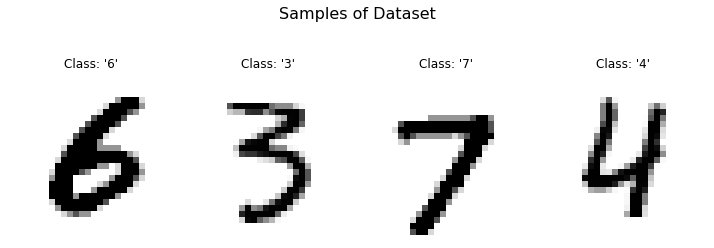

In [3]:
BATCH_SIZE = 32
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
}

# use helper to create the dataloaders
tmp = mnist_dataloader(data_transforms,
                           batch_size=BATCH_SIZE,
                           pred_size=0.01,
                           sample_size=6500)
dataloaders, dataset_sizes, class_names = tmp 
print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# preview the dataset
dataset_preview(dataloaders['val'])

In [20]:
model = models.resnet18(pretrained=False)
model_name = 'resnet18'

output_dir='output'
num_epochs = 5
# prepare the pre-trained model: 
#   Note the following considerations given our dataset for ResNet
#     -> MNIST data are 1-channel (grascale) of size and has 10 output classes
#     -> ResNet model expects 3-channel (RGB) images of size 224x224 as input 
#        and has 1000 output classes
#     == We must changet the last fully connected layer to match 10 classes
# keep features unchanged
num_features = model.fc.in_features
# change the output layer to match number of new classes
num_classes = 10
model.fc = nn.Linear(num_features, num_classes)
# change the first conv layer for single channel images
model.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
# ref: https://discuss.pytorch.org/t/altering-resnet18-for-single-channel-images/29198/10

# move model to the GPU
cudnn.benchmark = True

# use helper function to train the model (outputs model and Pandas DF)
print(f'\nTraining baseline model \'{model_name}\'...')
model, results_df,_ = train_model(device, model, dataloaders, 
                                       dataset_sizes, output_dir=output_dir, 
                                       num_epochs=num_epochs)

# save the data for others to use
 # <-- train_model should have created this dir
results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
results_df.to_csv(os.path.join(output_dir,results_file),
                  columns=results_df.columns)
print(f'> Saved results to \'{results_file}\'.')


Training baseline model 'resnet18'...

Epoch 0/4
----------
train Loss: 4.564 Acc: 0.312
val Loss: 31.7464 Acc: 0.1515

Epoch 1/4
----------
train Loss: 2.0088 Acc: 0.53
val Loss: 2.0453 Acc: 0.5576

Epoch 2/4
----------
train Loss: 3.5946 Acc: 0.459
val Loss: 1.7764 Acc: 0.4182

Epoch 3/4
----------
train Loss: 1.304 Acc: 0.602
val Loss: 0.8335 Acc: 0.6606

Epoch 4/4
----------
train Loss: 0.9008 Acc: 0.72
val Loss: 0.609 Acc: 0.8061
Training complete in 0.0m 4.3705456256866455s
Best val Acc: 0.8061
> Saved results to 'resnet18_results_2020-12-14T082336.csv'.


[]

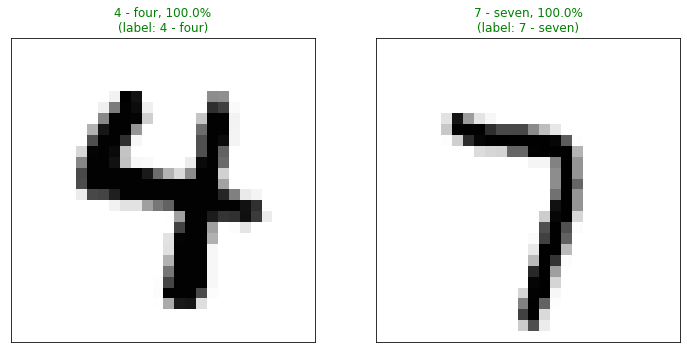

In [19]:
# Evaluate the model using the prediction set held-off
model.eval()
dataloader_iter = iter(dataloaders['pred'])
inputs, labels = next(dataloader_iter)
inputs = inputs.cuda()
# make predictions an plot the results
fig = plot_classes_preds(model,inputs,labels,class_names) 
plt.plot()